# OCT data processing Thorlabs Ganymede software

This is a demo to load and process 1D or 2D OCT data from raw Thorlabs OCT data. Dechirp

In [69]:
# load the relevant modulus
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from time import time

# Functions for reading OCT data
import ReadOCTfile

# Functions for processing OCT data
import DataProcessingOCT

 # load dechirp to be used in the calculations
chirp=np.fromfile('datademo/Chirp.data',np.float32)

Loading the data

In [3]:
t0=time()

file_name="datademo/2dimaging.oct"

# load the data from the file specified above
header,rawdata,spectrum,FOV=ReadOCTfile.OCTgetDataCombined(file_name,spectrumindex=0)   
Ascanav=int(header.Ocity.Acquisition.IntensityAveraging.AScans.string)

# process the data into a Bscan image
image=DataProcessingOCT.calc_Bscan(rawdata,spectrum, chirp,Ascanav,apodization='hanning',filters='none',objective='LK4')

t1=time()
print('It took ',t1-t0,' s to load and process file ',file_name)

It took  2.0971901416778564  s to load and process file  datademo/2dimaging.oct


(Text(0.5, 0, 'OPL-coordinate (pixels)'), Text(0, 0.5, 'OCT intensity (dB)'))

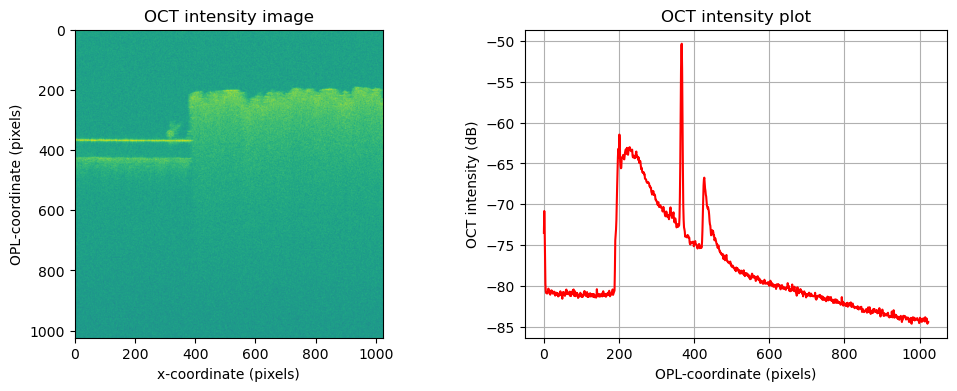

In [4]:
OCTintensity=np.abs(image)**2
dB_im=10*np.log10(OCTintensity)

N_z = OCTintensity.shape[0] # Number of pixels in depth
N_t = OCTintensity.shape[1] # Number of pixels in time

# Plot the figures
plt.figure(1, figsize=[12,4])
plt.subplot(121)
plt.imshow(dB_im), plt.title('OCT intensity image')
plt.xlabel('x-coordinate (pixels)'), plt.ylabel('OPL-coordinate (pixels)')

plt.subplot(122)
plt.title('Mean OCT intensity'), plt.title('OCT intensity plot')
plt.plot(10*np.log10(np.mean(OCTintensity, axis=1)), '-r'), plt.grid()
plt.xlabel('OPL-coordinate (pixels)'), plt.ylabel('OCT intensity (dB)')

This is a demo to calculate the diffusive particle dynamcics and calculate the diffusion coefficient.

In [5]:
file_name="datademo/silicadiffusion.oct"
chirp=np.fromfile('datademo/Chirp.data',np.float32)

#%% Initial parameters
dt = 1/36000 # Integration time [s]
n_kc = 1.33 # Refractive index [-]
apo = 300 # Gaussian spectral apodization window parameter

header,rawdata,spectrum,FOV=ReadOCTfile.OCTgetDataCombined(file_name,spectrumindex=0)   
image=DataProcessingOCT.calc_Bscan(rawdata,spectrum, chirp,Ascanav,apodization='hanning',filters='none',objective='LK4')

((0.001, 1), (0.0, 0.009), None, <matplotlib.legend.Legend at 0x233739145b0>)

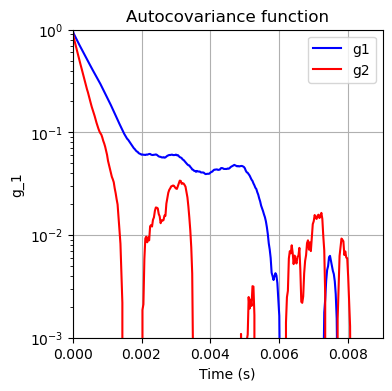

In [116]:
# 
z_time_trace=50

# Subtract mean for autocovariance
pad=np.zeros((30000,))

signalamp= image[z_time_trace,:] - np.mean(image[z_time_trace,:])
signalamp= np.concatenate((signalamp, pad))

signalint= np.real(image[z_time_trace,:]**2) - np.real(np.mean(image[z_time_trace,:]**2))
signalint= np.concatenate((signalint, pad))

# Calculate a triangular shape
n_pix=signalint.shape[0]                                    # Total pixel length of the time trace
norm1 = np.linspace(1,n_pix,n_pix)                      # Normalization for unbiased correlation
norm=np.concatenate((norm1, np.flip(norm1)[1:]))

g1 = sp.signal.correlate(signalamp, signalamp, mode='full', method='fft')/np.var(signalamp)/norm
g2 = sp.signal.correlate(signalint, signalint, mode='full', method='fft')/np.var(signalint)/norm

time=dt*np.linspace(-n_pix, n_pix, 2*n_pix-1)

plt.figure(1, figsize=[4,4])
plt.title('Autocovariance function')
plt.plot(time, np.real(g1), '-b', label='g1')
plt.plot(time, g2, '-r', label='g2')
plt.xlabel('Time (s)'), plt.ylabel('g_1')
plt.ylim([1e-3,1]), plt.xlim([0, 0.009]), plt.grid(), plt.legend()

(32768,)


((0.0, 1.0), (0.0, 0.003))

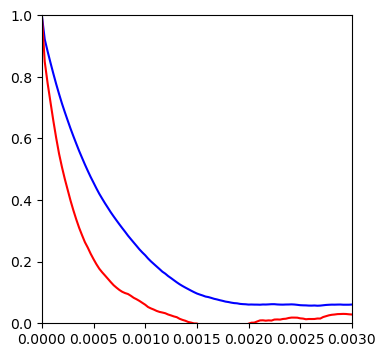

In [97]:

norm = np.linspace(n_pix,1,n_pix) # Normalization for unbiased correlation

signal_FFT = np.fft.fft(signalamp) # FFT of signal
G1 = np.fft.ifft(np.conj(signal_FFT)*signal_FFT, axis=0) # Autocorrelation
G1 = G1/norm/np.var(signalamp)


signal_FFT = np.fft.fft(signalint) # FFT of signal
G2 = np.fft.ifft(np.conj(signal_FFT)*signal_FFT, axis=0) # Autocorrelation
G2 = G2/norm/np.var(signalint)

time=dt*np.linspace(0, n_pix, n_pix)

plt.figure(1, figsize=[4,4])
plt.plot(time, G1, '-b', label='g2')
plt.plot(time, G2, '-r', label='g2')
plt.ylim([0,1]), plt.xlim([0,0.003])


In [141]:
file_name="datademo/intralipidflow.oct"

header,rawdata,spectrum,FOV=ReadOCTfile.OCTgetDataCombined(file_name,spectrumindex=0)
print(rawdata.shape)   
image=DataProcessingOCT.calc_Bscan(rawdata, spectrum, chirp, Ascanav, apodization='hanning', filters='none', objective='LK4')

(1423, 2048)


In [138]:
ndepth=1024
doppler=np.zeros([ndepth,])

for i in range(ndepth):
    doppler[i,]=np.mean(np.angle(image[i,:]*np.conj( np.roll(image[i,:], 1) )))

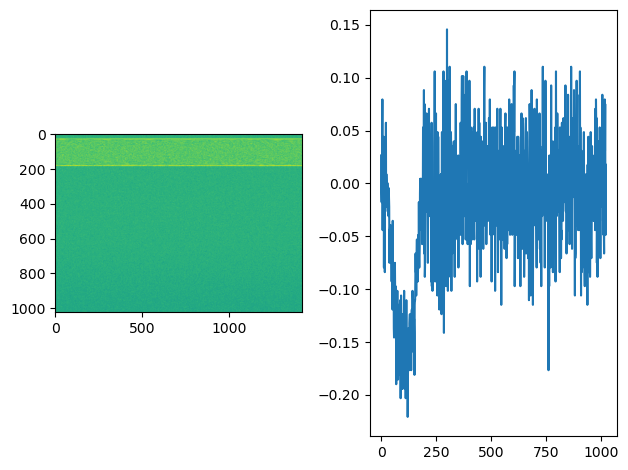

In [137]:
plt.subplot(121)    
plt.imshow(np.log10(np.abs(image)**2))

plt.subplot(122) 
plt.plot(doppler)   

plt.tight_layout()